# SIRD model playground

Given the following equations of the SIRD model

\begin{align*}
\frac{dS}{dt} &= -\beta \cdot S \cdot I \\
\frac{dI}{dt} &= \beta \cdot S \cdot I - (\gamma \cdot I) - (\delta \cdot I) \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \delta \cdot I
\end{align*}

Given the initial conditions: *population, cases, deaths, recovered* and *Basic reproductive rate (R0), Mortality rate ratio (M), Average infectios period (P)* it is possible to compute the correspondent ODEs and then obtain the *S, I, R, D* params

In [1]:
from epidemic_modelling.pso import LSTMConfig
from sird_base_model import SIRD
import matplotlib.pyplot as plt
import pandas as pd
from pso import MyPSO, BaselineConfig, TimeVaryingConfig
import os

class ExperimentType:
    BASELINE = 0
    TIME_VARYING = 1
    LSTM = 2

Experiment_type = ExperimentType.TIME_VARYING
#Experiment_type = ExperimentType.LSTM
# Experiment_type = ExperimentType.BASELINE

if Experiment_type == ExperimentType.BASELINE:
    config = BaselineConfig()
elif Experiment_type == ExperimentType.TIME_VARYING:
    config = TimeVaryingConfig()
else:
    raise ValueError("Invalid Experiment Type")
    
SEGMENTS = config.SEGMENTS if Experiment_type == ExperimentType.TIME_VARYING else 1
#config = LSTMConfig()

DAYS = config.DAYS
LAG = config.LAG

print(F"USING LAG: {LAG}, DAYS: {DAYS}")
parent_class = MyPSO(config=config)

USING LAG: 0, DAYS: 7


In [2]:
#First wave is february to may 2020
FIRST_WAVE = False
#Post first wave was june to sep 2020
FIRST_WAVE_POST = False
#Second wave was Oct to Dec 2020
SECOND_WAVE = False
#Third wave was jan to may 2021
THIRD_WAVE = False
#Post Third Wave was june to oct 2021
THIRD_WAVE_POST = False
#Fourth wave was nov 2021 to march 2022
FOURTH_WAVE = False

if FIRST_WAVE: 
    LAG = 0
    SEGMENTS = 15
elif FIRST_WAVE_POST:
    LAG = 16 *DAYS
    SEGMENTS = 19
elif SECOND_WAVE:
    LAG = 35 * DAYS
    SEGMENTS = 11
elif THIRD_WAVE:
    LAG = 48 *DAYS
    SEGMENTS = 22
elif THIRD_WAVE_POST:
    LAG = 67 *DAYS
    SEGMENTS = 23 
elif FOURTH_WAVE:
    LAG = 90 *DAYS
    SEGMENTS = 20

#Creating folders where we are going to save the plots for this specific experiment
PLOT_FOLDER = 'exp_l'+str(LAG*DAYS)+'_s'+str(SEGMENTS)
plot_folder_path = os.path.join(os.getcwd(), '../plots/'+PLOT_FOLDER)
if not os.path.exists(plot_folder_path):
    os.mkdir(plot_folder_path)

plot_inner_folder_name = 'p'+str(config.POPULATION_SIZE)+'_g'+str(int(config.MAX_GENERATIONS))
plot_inner_folder_path = os.path.join(plot_folder_path, plot_inner_folder_name)
print(plot_inner_folder_path)
if not os.path.exists(plot_inner_folder_path):
    os.mkdir(plot_inner_folder_path)


/home/thomas/Desktop/Didattica/AIS/2semestre/Bio-inspired/Epidemic-modelling/epidemic_modelling/../plots/exp_l0_s8/p50_g50


## Loading the solution file of the PSO run on SIRD

In [3]:
import os
print(os.getcwd())

/home/thomas/Desktop/Didattica/AIS/2semestre/Bio-inspired/Epidemic-modelling/epidemic_modelling


In [4]:
def get_params_from_file():
    FOLDER = f"../data/solutions/{config.NAME}.csv"
    file = os.path.join(os.getcwd(), FOLDER)
    print(file)
    with open(file) as f:
        res = pd.read_csv(f)
        # convert to single dict with keys = [params]
        res = res.to_dict(orient="records")
    return res

In [5]:
pso_params = get_params_from_file()
print(pso_params)

/home/thomas/Desktop/Didattica/AIS/2semestre/Bio-inspired/Epidemic-modelling/epidemic_modelling/../data/solutions/time_varying.csv
[{'beta': 0.3431333303390741, 'gamma': 0.0245311337664673, 'delta': 0.0078863399123258}, {'beta': 0.266488687552868, 'gamma': 0.0307916065998815, 'delta': 0.001}, {'beta': 0.2361811760666107, 'gamma': 0.0235143593656777, 'delta': 0.0203198790720419}, {'beta': 0.1787771250550976, 'gamma': 0.023855072963927, 'delta': 0.0192125422544975}, {'beta': 0.1009362083238143, 'gamma': 0.0185533596762981, 'delta': 0.001}, {'beta': 0.058764805243055, 'gamma': 0.0207627575794633, 'delta': 0.001}, {'beta': 0.047631077897715, 'gamma': 0.0215074183726019, 'delta': 0.0072632428333629}, {'beta': 0.0206967957780559, 'gamma': 0.001, 'delta': 0.001}]


## Loading and plotting raw data

In [6]:
'''
USE_SUSCEPTIBLE = True

# Viz real data
df = pd.read_csv('../data/raw.csv')
# Lineplot totale_positivi, dimessi_guariti, deceduti giving iloc

if Experiment_type == ExperimentType.BASELINE:
    row_interval = slice(LAG,LAG+DAYS+1)
elif Experiment_type == ExperimentType.TIME_VARYING:
    row_interval = slice(LAG,(DAYS*SEGMENTS)+LAG+1)
else:
    raise ValueError("Invalid Experiment Type")
original_df = df.iloc[row_interval, 1:4]
# Rename columns
original_df.columns = ['Original_I', 'Original_R', 'Original_D']
display(original_df)
original_df.plot(title="Original Data")

if USE_SUSCEPTIBLE:
    # Show only susceptible
    original_only_sus_df = df.iloc[row_interval, 4:5]
    original_only_sus_df.columns = ['Original_S']
    display(original_only_sus_df)
    original_only_sus_df.plot(title="Original Data - Only Susceptible")
'''


'\nUSE_SUSCEPTIBLE = True\n\n# Viz real data\ndf = pd.read_csv(\'../data/raw.csv\')\n# Lineplot totale_positivi, dimessi_guariti, deceduti giving iloc\n\nif Experiment_type == ExperimentType.BASELINE:\n    row_interval = slice(LAG,LAG+DAYS+1)\nelif Experiment_type == ExperimentType.TIME_VARYING:\n    row_interval = slice(LAG,(DAYS*SEGMENTS)+LAG+1)\nelse:\n    raise ValueError("Invalid Experiment Type")\noriginal_df = df.iloc[row_interval, 1:4]\n# Rename columns\noriginal_df.columns = [\'Original_I\', \'Original_R\', \'Original_D\']\ndisplay(original_df)\noriginal_df.plot(title="Original Data")\n\nif USE_SUSCEPTIBLE:\n    # Show only susceptible\n    original_only_sus_df = df.iloc[row_interval, 4:5]\n    original_only_sus_df.columns = [\'Original_S\']\n    display(original_only_sus_df)\n    original_only_sus_df.plot(title="Original Data - Only Susceptible")\n'

## Loading and plotting daily processed data

,Original_I,Original_R,Original_D
0,221,1,7
1,311,1,10
2,385,3,12
3,588,45,17
4,821,46,21
5,1049,50,29
6,1577,83,34
7,1835,149,52
8,2263,160,79
9,2706,276,107


,Original_S
0,59999771
1,59999678
2,59999600
3,59999350
4,59999112
5,59998872
6,59998306
7,59997964
8,59997498
9,59996911


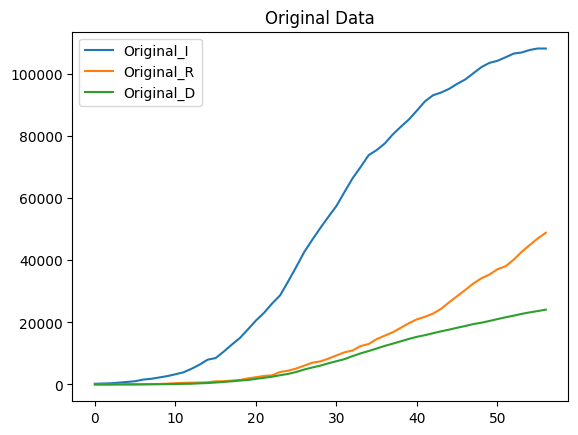

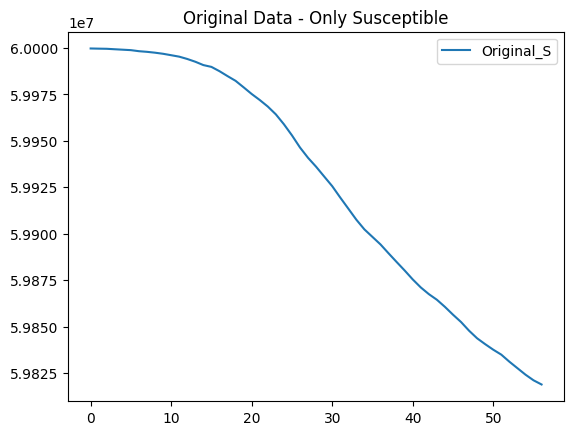

In [7]:
USE_SUSCEPTIBLE = True

# Viz real data
df = pd.read_csv('../data/daily_processed.csv')
# Lineplot totale_positivi, dimessi_guariti, deceduti giving iloc

if Experiment_type == ExperimentType.BASELINE:
    row_interval = slice(LAG,LAG+DAYS+1)
elif Experiment_type == ExperimentType.TIME_VARYING:
    row_interval = slice(LAG,(DAYS*SEGMENTS)+LAG+1)
else:
    row_interval = slice(LAG,(DAYS*config.SEGMENTS)+LAG+1)
original_df = df.iloc[row_interval, 1:4]
# Rename columns
original_df.columns = ['Original_I', 'Original_R', 'Original_D']
display(original_df)
original_df.plot(title="Original Data")



if USE_SUSCEPTIBLE:
    # Show only susceptible
    original_only_sus_df = df.iloc[row_interval, 4:5]
    original_only_sus_df.columns = ['Original_S']
    display(original_only_sus_df)
    original_only_sus_df.plot(title="Original Data - Only Susceptible")


## Computing SIRD from PSO obtained params

{'population': 60000000, 'initial_I': 221.0, 'initial_R': 1.0, 'initial_D': 7.0, 'initial_S': 59999771.0}
0
1
2
3
4
5
6
7


,Computed_I,Computed_R,Computed_D
0,221.000000,1.000000,7.000000
1,301.579223,7.361793,9.045208
2,411.382219,16.030844,11.832159
3,560.985548,27.842192,15.629306
4,765.535786,43.991721,20.821103
5,1044.856427,66.044591,27.910723
6,1425.594064,96.104717,37.574540
7,1945.068676,137.118826,50.759874
8,2459.602203,204.627305,52.952306
9,3110.132560,289.980064,55.724254


,Computed_S
0,5.999977e+07
1,5.999968e+07
2,5.999956e+07
3,5.999940e+07
4,5.999917e+07
5,5.999886e+07
6,5.999844e+07
7,5.999787e+07
8,5.999728e+07
9,5.999654e+07


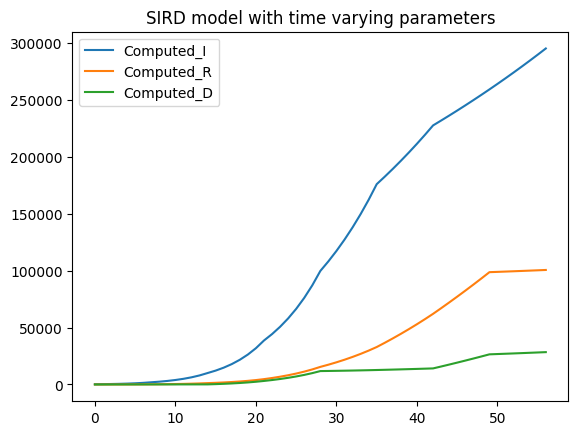

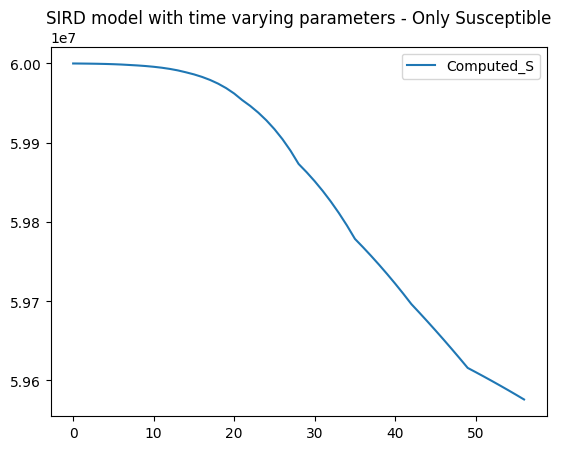

In [8]:
# Computing SIRD values using SIRD model + PSO obtained params

# Initial state of the system
initial_conditions, _ = parent_class.get_sird_from_data(start_week=LAG, end_week=LAG+DAYS, population=parent_class.population)
model_df = pd.DataFrame({'Computed_I': [], 'Computed_R': [], 'Computed_D': []})
model_df = pd.concat([model_df, pd.DataFrame({'Computed_I': initial_conditions['initial_I'], 'Computed_R': initial_conditions['initial_R'], 'Computed_D': initial_conditions['initial_D']}, index=[0])])

if USE_SUSCEPTIBLE:
    model_only_sus_df = pd.DataFrame({'Computed_S': initial_conditions['initial_S']}, index=[0])
    
print(initial_conditions)
if Experiment_type == ExperimentType.BASELINE:
    params = pso_params[0]
    model_base = SIRD(beta=params['beta'], gamma=params['gamma'], delta=params['delta'])
    model_base.solve(initial_conditions, time_frame=DAYS)
    s,i,r,d, _ = model_base.get_sird_values().values()
    model_df = pd.DataFrame({'Computed_I': i, 'Computed_R': r, 'Computed_D': d})
    model_df.reset_index(drop=True, inplace=True)
    display(model_df)
    model_df.plot(title='SIRD model with baseline parameters')

    if USE_SUSCEPTIBLE:
        model_only_sus_df = pd.DataFrame({'Computed_S': s})
        display(model_only_sus_df)
        model_only_sus_df.plot(title='SIRD model with baseline parameters - Only Susceptible')

elif Experiment_type == ExperimentType.TIME_VARYING:
    # Iterate on each segment
    for segment_idx, params in enumerate(pso_params):
        print(segment_idx)
        model_tvar = SIRD(beta=params['beta'], gamma=params['gamma'], delta=params['delta'])
        model_tvar.solve(initial_conditions, time_frame=DAYS)
        s,i,r,d, _ = model_tvar.get_sird_values().values()
        initial_conditions = {'population': parent_class.population, 'initial_I': i[-1], 'initial_R': r[-1], 'initial_D': d[-1], 'initial_S': s[-1]}
        model_df = pd.concat([model_df, pd.DataFrame({'Computed_I': i[1:], 'Computed_R': r[1:], 'Computed_D': d[1:]})])
        if USE_SUSCEPTIBLE:
            model_only_sus_df = pd.concat([model_only_sus_df, pd.DataFrame({'Computed_S': s[1:]})])
    model_df.reset_index(drop=True, inplace=True)
    display(model_df)
    model_df.plot(title="SIRD model with time varying parameters")

    if USE_SUSCEPTIBLE:
        model_only_sus_df.reset_index(drop=True, inplace=True)
        display(model_only_sus_df)
        model_only_sus_df.plot(title="SIRD model with time varying parameters - Only Susceptible")


Weights = [S: 1, I: 1, R: 1, D: 1]
Generations: 50.0
Population: 50
Segments: 8


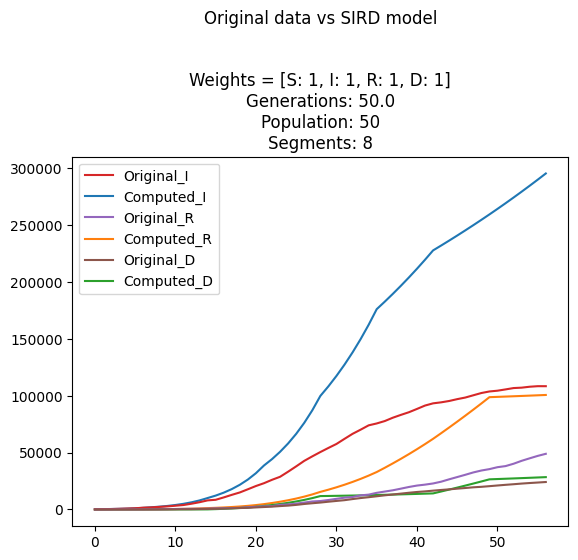

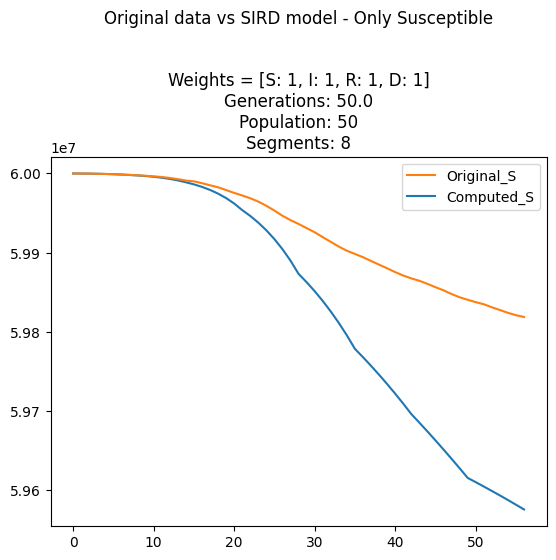

In [9]:
# Compare the original data with the computed sird values
# Change the order of legend items so that i have Original_I, Computed_I, Original_R, Computed_R, Original_D, Computed_D

# params contains an array of dict contianing beta, gamma, delta 
# i want to put them in the title using markdown syntax
params_len = len(pso_params)
# Get all params from the dict given a key. E.g. get_pk(params, 'beta') -> [0.1, 0.2, 0.3]
get_pk = lambda k: [round(p[k],3) for p in pso_params]
params_title = f"\nWeights = [S: {config.weight_S}, I: {config.weight_I}, R: {config.weight_R}, D: {config.weight_D}]\nGenerations: {config.MAX_GENERATIONS}\nPopulation: {config.POPULATION_SIZE}\nSegments: {SEGMENTS}"#\n\nBetas: {get_pk('beta')}\nGammas: {get_pk('gamma')}\nDeltas: {get_pk('delta')}\n"
print(params_title)
original_df.plot(ax=model_df.plot(), title=f'Original data vs SIRD model\n\n{params_title}')
# 0 3 1 5 2 5
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 4, 1, 5, 2]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.savefig(os.path.join(plot_inner_folder_path,'_cr'+str(config.cognitive_rate)+'_sr'+str(config.social_rate)+'_neigh'+str(config.neighborhood)+'_i'+str(config.inertia)+'.png'))

if USE_SUSCEPTIBLE:
    original_only_sus_df.plot(ax=model_only_sus_df.plot(), title=f'Original data vs SIRD model - Only Susceptible\n\n{params_title}')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig(os.path.join(plot_inner_folder_path,'_cr'+str(config.cognitive_rate)+'_sr'+str(config.social_rate)+'_i'+str(config.inertia)+'susc.png'))
    

## Test_augmented dataset

In [10]:
# Test augmented dataset
df_augmented = pd.read_csv("../data/augmented.csv")

# Consider initial conditions
initial_conditions, _ = parent_class.get_sird_from_data(start_week=0, end_week=DAYS, population=parent_class.population)
display(initial_conditions)
# keep only beta, gamma, delta columns
df_augmented = df_augmented[['beta', 'gamma', 'delta']][:-1]
display(df_augmented)

{'population': 60000000,
 'initial_I': 221.0,
 'initial_R': 1.0,
 'initial_D': 7.0,
 'initial_S': 59999771.0}

,beta,gamma,delta
0,0.420816,-0.000000,0.013575
1,0.250805,0.006431,0.006431
2,0.649355,0.109091,0.012987
3,0.404766,0.001701,0.006803
4,0.292331,0.004872,0.009744
...,...,...,...
1530,0.000965,0.000574,-0.000000
1531,0.000802,0.000155,-0.000000
1532,0.000512,0.000342,-0.000000
1533,0.001628,0.001122,0.000035


,Computed_I,Computed_R,Computed_D
0,3.322498e+02,1.000000e+00,1.070835e+01
1,4.986645e+02,1.000000e+00,1.625555e+01
2,7.481678e+02,1.000000e+00,2.457241e+01
3,1.125266e+03,1.000000e+00,3.714254e+01
4,1.692014e+03,1.000000e+00,5.603462e+01
5,2.542260e+03,1.000000e+00,8.437722e+01
6,3.820357e+03,1.000000e+00,1.269829e+02
7,4.846609e+03,2.873858e+01,1.547216e+02
8,6.148367e+03,6.392455e+01,1.899078e+02
9,7.799869e+03,1.085652e+02,2.345487e+02


<Axes: title={'center': 'SIRD model with augmented parameters'}>

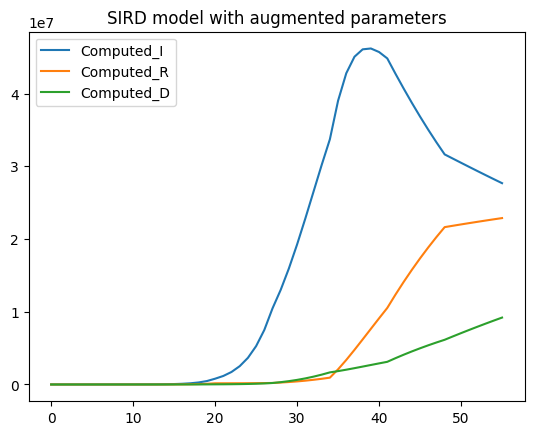

In [11]:
model_df = pd.DataFrame({'Computed_I': [], 'Computed_R': [], 'Computed_D': []})
# use initial conditions from line 0 of augmented df
for week in range(0, SEGMENTS):
    augmented_params = df_augmented.iloc[week]
    # print(augmented_params)
    model_augmented = SIRD(beta=augmented_params['beta'], gamma=augmented_params['gamma'], delta=augmented_params['delta'])
    model_augmented.solve(initial_conditions, time_frame=7)
    s,i,r,d, _ = model_augmented.get_sird_values().values()
    initial_conditions = {'population': parent_class.population, 'initial_I': i[-1], 'initial_R': r[-1], 'initial_D': d[-1], 'initial_S': s[-1]}
    model_df = pd.concat([model_df, pd.DataFrame({'Computed_I': i[1:], 'Computed_R': r[1:], 'Computed_D': d[1:]})])
    if USE_SUSCEPTIBLE:
        model_only_sus_df = pd.concat([model_only_sus_df, pd.DataFrame({'Computed_S': s[1:]})])


model_df.reset_index(drop=True, inplace=True)
display(model_df)
model_df.plot(title="SIRD model with augmented parameters")
